In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from IPython.display import clear_output
from keras.utils import to_categorical
import seaborn as sns
sns.set()
# We import the agents and the environment from the 
# modules created in advance.

class Bandit(object):
    def __init__(self, n_arms=2, x_min=0, x_max=10, max_reward=1):
        self.max_reward = max_reward
        self.n_arms = n_arms
        self.x_min = x_min
        self.x_max = x_max
        self.target_arm = random.randint(0, n_arms-1)
        self.total_reward = 0
        reward = 0
    
    def generate_values(self):
        self.x_arms=[]
        for i in range(0, self.n_arms):
            self.x_arms.append(random.uniform(self.x_min,self.x_max))
    def take_action(self, action):
        return self.x_arms[action]
    def test(self):
        test_pre = random.uniform(self.x_min,self.x_max)
        test_post = test_pre*self.x_arms[self.target_arm]
        return test_pre, test_post
    
    def give_reward(self, prediction, observed, sigma=0.05):
        x = (observed-prediction)/observed
        reward = self.max_reward*np.exp(-0.5*(x/sigma)**2)
        self.total_reward = self.total_reward + reward
        return reward
    def reshape_for_analyzer(self, measurements, target):
        """ Reshapes the measurements and the target value in a suitable
        format for a Keras analyzer
        
        :param measurements: Measurements to give the Analyzer to make the 
                             prediction
        :type measurements: numpy array
        :param target: Target value to fit.
        :type target: float
        :return: X_train (inputs to the Analyzer), y_train (Target value to fit)
        :rtype: pandas DataFrame, pandas DataFrame
        """        
        X_train = pd.DataFrame(measurements.reshape(-1,len(measurements)))
        y_train = pd.DataFrame(target*np.ones((1,1)))
        return X_train, y_train
    def get_measurements(self, action1, test_in):
        """ Transforms the actions and the environmental elements into an array
        to feed the Analyzer.
        
        :param action1: Action performed by the first experimenter.
        :type action1: int
        :param outcome1: Outcome of the first use of the sensors.
        :type outcome1: float / int
        :param action2: Action performed by the second experimenter.
        :type action2: int
        :param outcome_2: Outcome of the second use of the sensors.
        :type outcome_2: float / int
        :param V: Velocity of the test bullet.
        :type V: float
        :return: Numpy array containing all the arguments
        :rtype: numpy array
        """        
        return np.array([action1, test_in])
    
    
        

In [169]:
class Q_Learning(object):
    def __init__(self, iterations, output_size, learning_rate=0.01, discount=0,
    exploration_rate=1):
        """Agent based on the classic Q-Learning algorithm with no inputs.
        
        :param iterations: Number of iterations for the training. This parameter
                           is used to calculate the decrease on the exploration 
                           rate.
        :type iterations: int
        :param output_size: Number of actions available for the agent.
        :type output_size: int
        :param learning_rate: Learning rate for Q-Learning update rule, defaults
                              to 0.1
        :type learning_rate: float, optional
        :param discount: Discount factor. If it's 0 only cares about 
                         immediate reward. The closer to one the more 
                         it values future rewards, defaults to 0
        :type discount: int, optional
        :param exploration_rate: Initial exploration rate for the epsilon-greedy
                                 decision algorithm, defaults to 1
        :type exploration_rate: int, optional
        """

        self.output_size = output_size
        self.q_table = [0] * self.output_size # Spreadsheet (Q-table) 
        # for rewards 
        # accounting, 5 possible actions
        self.learning_rate = learning_rate # How much we appreciate the new 
        # -value over current
        self.discount = discount # How much we appreciate future 
        # reward over current
        self.exploration_rate = exploration_rate # Initial exploration rate
        self.exploration_delta = exploration_rate / iterations # Shift 
        # from exploration to exploration        
    def get_next_action(self):
        """Uses the model and the exploration rate to choose a an action with an
        epsilon-greedy decision algorithm.
        
        :return: Integer representing the action
        :rtype: int
        """        
        if random.random() > self.exploration_rate:
            return self.greedy_action()
        else:
            return self.random_action()
    def greedy_action(self):
        """ Takes the index of the maximum Q-Value to choose an action.
        
        :return: Integer representing the model action
        :rtype: int
        """        
        return np.argmax(self.q_table)
    def random_action(self):
        """Generates a random integer to choose a random action.
        
        :return: Integer representing the random action
        :rtype: int
        """        
        return random.randint(0,self.output_size-1)
    def update(self, action, reward):
        """ Takes the last action taken and the reward obtained to update the 
        Q-Value of the action by using the Bellman equation.
        
        :param action: Last action taken by the agent
        :type action: int
        :param reward: Reward obtained with the taken action
        :type reward: float
        """        
        old_value = self.q_table[action]
        # What would be our best next action?
        future_action = self.greedy_action()
        # What is reward for th best next action?
        future_reward = self.q_table[future_action]
        # Main Q-table updating algorithm
        new_value = old_value + self.learning_rate * (reward + 
        self.discount*future_reward - old_value)
        self.q_table[action] = new_value
        #Each train we update the exploration rate.
        if self.exploration_rate > 0.0001:
            self.exploration_rate = self.exploration_rate*(1-7*self.exploration_delta)

In [154]:
import random
import numpy as np
import tensorflow as tf
from collections import deque
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import layers
from keras.models import load_model
class Two_Layers_single_output(object):
    def __init__(self, input_size, learning_rate=0.001):
        """ This class is just a two-layer Keras neural network to process the
        data taken by the experimenter to produce a single output.
        :param input_size: Number of inputs feeded to the analyzer
        :type input_size: int
        :param learning_rate: Gradient descent (Adam) learning rate, defaults 
                              to 0.001
        :type learning_rate: float, optional
        """        
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.model = self.build_model()

    def build_model(self):
        """Uses keras to build de model. You should modify here the code to
        change the neural network architecture. Default to a 
        *input_sizex16x16x1* fully connected sequential network.
        
        :return: Keras model for the agent using the specified structure. 
        :rtype: keras model
        """        
        model = Sequential([
        layers.Dense(16,activation = 'relu', input_shape=[self.input_size]),
        layers.Dense(16, activation = 'relu'),
        layers.Dense(1)
        ])
        optimizer = Adam(self.learning_rate)
        model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
        return model
    def train(self, X_train, y_train):
        """ Fit the model with the given data an target.
        
        :param X_train: Input data for the model
        :type X_train: Keras valid input data 
        :param y_train: Target value for the input data
        :type y_train: numpy array / float
        """        
        self.model.fit(X_train, y_train, batch_size=1, epochs = 1, verbose = 0)
        
    def predict(self, X_test):
        """ Uses the model to predict a value
        
        :param X_test: Input data for the model
        :type X_test: Keras valid input data
        :return: Prediction of the target value
        :rtype: numpy array/float
        """        
        return self.model.predict(X_test)

60000/60000 episodes(100.0%)
Elapsed time: 6 min 1s
Est. completion time: 6 min 1s,
        Est. remaining time: 0 min 0s
Training completed!


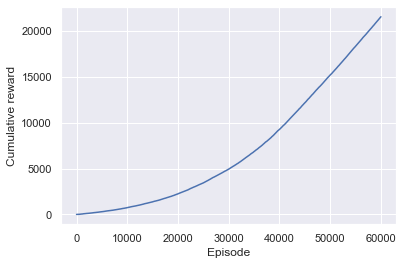

,Target arm,Target arm value,Action,Outcome,Test_in,Reward,Predicted_out,Test_out,Exploration rate
0,7,9.264,0,1.874,3.082,0.000,0.000,28.553,1.000
1,7,6.693,6,1.730,0.054,0.000,-0.959,0.361,1.000
2,7,5.757,6,7.993,9.320,0.000,-3.560,53.657,1.000
3,7,5.717,7,5.717,4.068,0.000,-2.437,23.259,1.000
4,7,2.087,5,5.307,5.424,0.000,-2.256,11.316,1.000
...,...,...,...,...,...,...,...,...,...
59995,7,7.373,7,7.373,1.592,0.079,13.063,11.741,0.001
59996,7,6.805,7,6.805,6.327,0.417,45.905,43.056,0.001
59997,7,5.812,7,5.812,5.218,0.887,31.069,30.327,0.001
59998,7,6.431,7,6.431,8.362,0.510,56.892,53.773,0.001


In [176]:
# CONSTANTS, INSTANTIATIONS, INITIALIZATION ===============================

N_Episodes = 60000 # Number of episodes to train 
count = 0 # Initialization of a counter
n_arms = 8
# We instantiate the classes of each element
experimenter = Q_Learning(iterations=N_Episodes, output_size=n_arms)
analyzer = Two_Layers_single_output(input_size=2)
env = Bandit(n_arms=n_arms)
# Save time for verbose purposes
t0 = time.time()
t1 = time.time()

# First random initialization of the variables. This part is needed since 
# some recurrent parts of the loop need from some data to start with.
env.generate_values()
action = experimenter.get_next_action()
outcome = env.take_action(action)
train_in, train_out = env.test()
test_in, test_out = env.test()
y_predicted = [0]
reward = 0

# Auxiliar variables for collecting data
values = []
df=pd.DataFrame(columns = ['Target arm','Target arm value', 'Action', 
                           'Outcome 1', 'Test_in', 'Reward', 
                           'Predicted_out', 'Test_out', 'Exploration rate'])
total_reward_list = []

# MAIN LOOP =================================================================
K = True
while count < N_Episodes:
    if K and experimenter.exploration_rate<0.0001:
        analyzer = Two_Layers_single_output(input_size=2)
        K = False
    
    values.append([env.target_arm, env.x_arms[env.target_arm], 
                   action, outcome, test_in,  float(reward),
                   y_predicted[0], test_out, experimenter.exploration_rate])
    total_reward_list.append(env.total_reward)
    env.generate_values()
    action = experimenter.get_next_action()
    outcome = env.take_action(action)

    train_in, train_out = env.test()
    measurements = env.get_measurements(outcome, train_in)
    X_train, y_train = env.reshape_for_analyzer(measurements, train_out) 
    analyzer.train(X_train, y_train)

    test_in, test_out = env.test()
    measurements = env.get_measurements(outcome, test_in)
    X_test, y_test = env.reshape_for_analyzer(measurements, test_out)

    y_predicted = analyzer.predict(X_test)[0]
    reward = env.give_reward(y_predicted, test_out)
    experimenter.update(action, reward)

# Display training status....................................................
    count = count + 1
    refresh_rate = 100
    if count % (N_Episodes/refresh_rate) == 0:
        clear_output()
        t2 = time.time()
        m, s = divmod(t2-t1, 60)
        mt, st = divmod(t2-t0, 60)
        me, se = divmod(((t2-t0)/count)*N_Episodes, 60)
        mr, sr = divmod(((t2-t0)/count)*N_Episodes-t2+t0, 60)
        print (str(int(count)) + '/' +  str(N_Episodes) + " episodes" + 
               '(' + str(100*count/N_Episodes)+ '%)')
        print('Elapsed time: {} min {}s'.format(int(mt), int(st)))
        print("""Est. completion time: {} min {}s,
        Est. remaining time: {} min {}s""".format(int(me), int(se), int(mr),
                                                  int(sr)))
        t1 = time.time()
print('Training completed!')


plt.plot(range(len(total_reward_list)), total_reward_list)
plt.ylabel("Cumulative reward")
plt.xlabel("Episode")
plt.show()


df=pd.DataFrame(values, columns = ['Target arm','Target arm value', 'Action', 
                           'Outcome', 'Test_in', 'Reward', 
                           'Predicted_out', 'Test_out', 'Exploration rate'])
df.to_csv('Armed-Bandit.csv')
df.round(3)

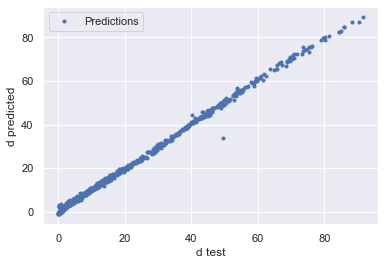

In [177]:
sample_size = 0.01
sample=df.loc[np.r_[N_Episodes-N_Episodes*sample_size:N_Episodes], :]
# We plot an histogram of the zone distribution to observe the expected
# unbalanced distribution of landing zones

plt.plot(sample['Test_out'], sample['Predicted_out'],'.',label="Predictions")
plt.xlabel('d test')
plt.ylabel('d predicted')
plt.legend()

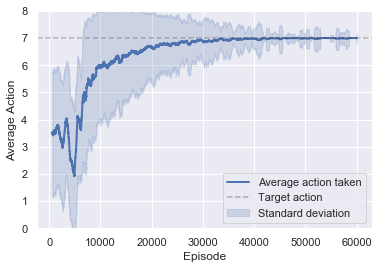

In [184]:
window=int(N_Episodes/100)
smooth_path= df['Action'].rolling(window=window).mean()
path_deviation = df['Action'].rolling(window=window).std()
under_line     = (smooth_path-path_deviation)
over_line      = (smooth_path+path_deviation)
plt.plot(smooth_path, linewidth=2, label ='Average action taken') #mean curve.
plt.fill_between(path_deviation.index, under_line, over_line, color='b', alpha=0.2,label ='Standard deviation')
plt.xlabel('Episode')
plt.ylabel('Average Action')
plt.ylim(0, n_arms)
plt.axhline(y=env.target_arm,color='k',linestyle='--',alpha=0.3, label='Target action')
plt.legend()


In [185]:
actions = np.zeros((N_Episodes+1,n_arms))
for i in range(N_Episodes):
    for j in range(n_arms):
        if df['Action'][i] == j:
            actions[i+1,j]=actions[i,j]+1
        else:
            actions[i+1,j]=actions[i,j]
actions = pd.DataFrame(actions)


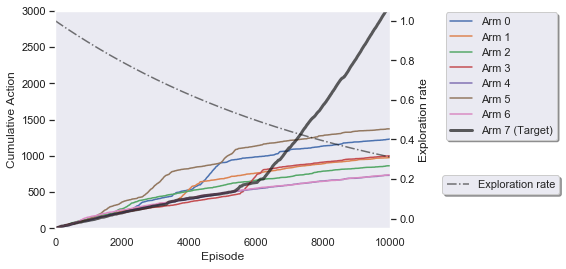

In [188]:
fig, ax1 = plt.subplots()
color = 'k'
window = 1
marker=0
eps=1
# while eps>0.001:
#     eps=df['Exploration rate'][marker]
#     marker=marker+1

avg = actions.rolling(window=window).mean()
for i in range(n_arms):
    if not i==env.target_arm:
        ax1.plot(avg[i], label = 'Arm ' + str(i))
ax1.plot(avg[env.target_arm],'k-', linewidth=3, alpha=0.7,label='Arm ' + str(env.target_arm) + ' (Target)' )
plt.xlabel('Episode')
plt.ylabel('Cumulative Action')
ax1.legend(loc='center left', bbox_to_anchor=(1.15, 0.7), shadow=True, ncol=1)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Exploration rate', color=color)  # we already handled the x-label with ax1
ax2.plot(df['Exploration rate'],'k-.', label = 'Exploration rate', alpha=0.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.axvline(x=marker/len(df),color='y',linestyle='-',alpha=0.3)
ax2.grid(False)
lgd=ax2.legend(loc='center left', bbox_to_anchor=(1.14, 0.2), shadow=True, ncol=1)
ax1.set_xlim([0,10000])
ax1.set_ylim([0,3000])
fig.savefig('Cum-action-MAB.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')